In [ ]:
#!pip install -q sciunit==0.2.3

In [1]:
import sciunit
import numpy as np

import os
import json
import matplotlib
# To avoid figures being plotted on screen (we wish to save to file directly)
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

In /home/pedroernesto/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/pedroernesto/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/pedroernesto/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/pedroernesto/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/pedroernesto/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed 

# Load the Observation data

In [ ]:
def format_observation(observation_path=None):
        
    #self.observation_path = observation_path
    #self.observation_key = observation_key

    load_data=m.load(observation_path)
    observation_key = list(load_data.keys())[0]
    observation = {observation_key: np.array(load_data[observation_key])}
   
    return observation

In [ ]:
# observation=format_observation(observation_path='')

In [ ]:
observation_key = list(observation.keys())[0]
plt.plot(observation[observation_key])

# Define the Model capability

In [5]:
class cap_generates_spikeraster(sciunit.Capability):
    """Indicates that the model has a spike raster as output. """
    
    def model_prediction(self):
        ...
        raise NotImplementedError()
       
    def get_spikeraster(self):
        """This function is called by the test, and then the model_prediction function"""            
        spikeraster = self.spikeraster
        return spikeraster

# Define the Model class

In [6]:
class BezaireSoltesz_CA1model(sciunit.Model,cap_generates_spikeraster):
    
    def __init__(self, model_path = '../modeldbca1', results_dir='results', run_dir=None):
        sciunit.Model.__init__(self, name = "BezaireSoltesz_CA1model")
        self.result_path = os.path.join(model_path, results_dir, run_dir)
        
    def read_model_result(self, file_name):
        file_path = os.path.join(self.result_path, file_name)
        with open(file_path, 'r') as fp:
            mod_data = np.genfromtxt(fp)
        return mod_data    
        
    def model_prediction(self):
        return self.spikeraster

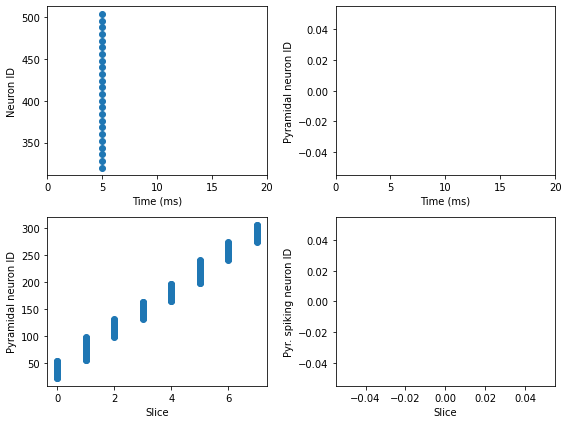

In [7]:
model = BezaireSoltesz_CA1model(run_dir = 'run_Sasaki_Scale_100_SimDuration_20_Procs_8')

fig, ax = plt.subplots(2, 2, figsize=(8,6))

spikeraster_data = model.read_model_result('spikeraster_0.dat')
ax[0,0].plot(spikeraster_data[:,0], spikeraster_data[:,1], 'o')
ax[0,0].set(ylabel='Neuron ID', xlabel ='Time (ms)', xlim = [0,20])

neuron_slice_data = model.read_model_result('neuron_slice_ids.dat')
ax[1,0].plot(neuron_slice_data[:,1], neuron_slice_data[:,0], 'o')
ax[1,0].set(ylabel='Pyramidal neuron ID', xlabel='Slice')

# Filtering out the Pyramidal neurons from the spikeraster data
pyr_spikes_inds = np.in1d(spikeraster_data[:,1], neuron_slice_data[:,0])
pyr_spikeraster_data = spikeraster_data[pyr_spikes_inds,:]
ax[0,1].plot(pyr_spikeraster_data[:,0], pyr_spikeraster_data[:,1], 'o')
ax[0,1].set(ylabel='Pyramidal neuron ID', xlabel ='Time (ms)', xlim = [0,20])

# Filtering out the Pyramidal neurons from the slicing data 
pyr_slices_inds = np.in1d(neuron_slice_data[:,0], pyr_spikeraster_data[:,1])
ax[1,1].plot(neuron_slice_data[pyr_slices_inds,1], neuron_slice_data[pyr_slices_inds,0], 'o')
ax[1,1].set(ylabel='Pyr. spiking neuron ID', xlabel='Slice')

fig.tight_layout()

# Define the Score

In [ ]:
import sciunit.utils as utils
import quantities as pq

from scipy.stats import power_divergence
from collections import namedtuple

NeymanResult = namedtuple('NeymanResult', ('statistic_n', 'pvalue'))
class NeymanScore(sciunit.Score):
    """
    A Neyman score. A float giving the result of
    a Neyman goodness-of-fit test
    """

    _allowed_types = (float,tuple,)

    _description = ('A Neyman score. A float giving the result'
                    'of a Neyman goodness-of-fit test')

    @classmethod
    def compute(cls, observation, prediction):
        """
        Computes a Neyman score from an observation and a prediction.
        """

        obs_values = observation[~np.isnan(observation)]
        pred_values = prediction[~np.isnan(prediction)]

        '''
        assert(all(x<=1.00 for x in obs_values) and all(x<=1.00 for x in pred_values)), \
            "Probabiltity values should not be larger than 1.0"
        obs_values *= 100
        pred_values *= 100
        '''
        
        if type(obs_values) is pq.quantity.Quantity:
            obs_values = obs_values.magnitude
        if type(pred_values) is pq.quantity.Quantity:
            pred_values = pred_values.magnitude

        Neyman_Result = power_divergence(f_obs=pred_values, f_exp=obs_values, lambda_='neyman')

        utils.assert_dimensionless(Neyman_Result.statistic)
        utils.assert_dimensionless(Neyman_Result.pvalue)

        # Obtaining a score value normalized respect to the mean and std of the Chi-squared distribution
        dof = len(obs_values)-1  # degrees of freedom for the Chi-squared distribution
        stat = Neyman_Result.statistic
        chisq_mean = dof
        chisq_std = np.sqrt(2*dof)
        stat_n = abs(stat-chisq_mean)/chisq_std
        Neyman_result = NeymanResult(stat_n, Neyman_Result.pvalue)

        return NeymanScore(Neyman_result)

    @property
    def sort_key(self):
        return self.score

    def __str__(self):
        return 'Neyman-score = %.5f' % self.score.statistic_n

# Define the Test

In [ ]:
import sciunit.scores as sci_scores
import math

In [ ]:
class Sasaki_experiment_test(sciunit.Test):
    
    score_type = sciunit.Score
    
    def __init__(self, observation=None, name="Sasaki_experiment_test", base_directory=None):

        self.description = "tests model features related with Sasaki experiment"
        require_capabilities = cap_generates_spikeraster

        if not base_directory:
            base_directory = "."
        self.path_test_output = base_directory
        # create output directory
        if not os.path.exists(self.path_test_output):
            os.makedirs(self.path_test_output)

        self.figures = []
        sciunit.Test.__init__(self, observation, name)
        self.observation = observation
           
    def generate_prediction(self, model, verbose=False):
        """Implementation of sciunit.Test.generate_prediction"""

        model_dict = model.model_prediction()    
        model_key = list(model_dict.keys())[0]
        prediction_val = np.array(model_dict[model_key])

        observation_key = list(self.observation.keys())[0]
        prediction_val = prediction_val[0:len(self.observation[observation_key])] #corrects length, take out later
        prediction_dict = {model_key: prediction_val}
        
        return prediction_dict
      
    def compute_score(self, observation, prediction, verbose=True):
        """Implementation of sciunit.Test.score_prediction"""

        #Computing the scores - kept for more keys in observation
        #cell_t = list(observation.keys())[0]  # Cell type
        #score_cell_dict = dict.fromkeys([key0 for key0 in prediction.keys()], [])
        #obs_features = copy.deepcopy(list(observation.values()))[0]
        #score_feat_dict = dict()

        # compare prediction against observation
        prediction_key = list(prediction.keys())[0]
        observation_key = list(observation.keys())[0]
        score = sum(map(abs,observation[observation_key] - prediction[prediction_key]))/len(observation[observation_key])
        self.score = round(score[0], 10)
        
        # ---------------------- Saving relevant results ----------------------
        # Saving figures
        fig_prediction = plt.plot(prediction[prediction_key])
        fig_observation = plt.plot(observation[observation_key])
        self.figures.extend([fig_prediction,fig_observation])

        '''
        # Saving json file with scores
        json_scores_file = mph_plots.jsonFile_MorphStats(testObj=self, dictData=self.score_feat_dict,
                                                         prefix_name="scores_summary_")
        json_scores_files = json_scores_file.create()
        self.figures.extend(json_scores_files)

        # Saving table with results
        txt_table = mph_plots.TxtTable_MorphStats(testObj=self)
        table_files = txt_table.create()
        self.figures.extend(table_files)

        # Saving figure with scores bar-plot
        barplot_figure = mph_plots.ScoresBars_MorphStats(testObj=self)
        barplot_files = barplot_figure.create()
        self.figures.extend(barplot_files)
        '''

        return sciunit.Score(self.score)
    
    def bind_score(self, score, model, observation, prediction):
        score.related_data["figures"] = self.figures
        return score

# Run the Test

In [ ]:
test=Sasaki_experiment_test(observation)

In [ ]:
test.judge(model)